<a href="https://colab.research.google.com/github/rmoglin/BIX_F24/blob/main/moglin_lab8_patch_foraging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 8 - Patch foraging

This lab has 4 main components designed to give provide an theoretical and experiental/interactive understanding of foraging in patchy environments.

Sections:
1. Consider foraging in "patchy" environments, and build a simulated patchy environment.
1. Predict and evaluate the behavior of agents with different exploration strategies in the patchy environment.
1. Predict and evaluate how agents' behavior & performance will change as characteristics of the patchy environment change.


## Background

### Real environments are "patchy".
- So far, we've been playing around with simulated environments where food ("targets") are spread uniformly over space.
- In reality, environments are often "patchy". For example, berries or flowers may be concentrated on isolated bushes, which are spaced apart from one another

### Patchy environments define the foraging problem.
- The problem of foraging requires that an organism navigate through an environment to find food, balancing the metabolic costs of movement with the energy provided by collected morsels.
- In an environment where targets are dispersed uniformly, foraging is rather simple - moving around from via some form of random walk, collecting targets, perhaps with behavior imformed by scent cues.
- A patchy environment complicates things - with no food in between patches, between-patch movement can become dangerous at long transit times. Patchy environments thus demand a foraging strategy that is sensitive to the sparsely-dense stucture of food availability.

### We can think of optimal foraging in terms of a simplified model.
- Charnov (1976) proposed a model of optimal foraging.
- Charnov's model formulates foraging space as divided into sections (patches) of different types, and the inter-patch space between them. See the illustration of this from his paper below (and consider how this simple model matches the real environment above so much better than uniformly distributed targets!).
![Charnov patch model illustration screenshot](https://raw.githubusercontent.com/CoAxLab/BiologicallyIntelligentExploration/main/Labs/Charnov_patches_screenshot.png)
- When we think about foraging in this way, it becomes clear that there is an important distinction between time spent *in* and *between* patches.
- Critically, off-patch time and on-patch time (for different patch types) determines energy intake rate for organisms.
- In Charnov's model, within-patch energy is depleted as a forager consumes the energy within that patch. Thus there is a point at which an optimal forager should leave a patch in aims of finding another. This is where the formulas in his marginal value come into play.

Next up, let's get set up to run some patch environment simulations!

## Section 0 - Setup

The setup is the same as prior labs.

Install our code libraries as usual

In [1]:
!pip install --upgrade git+https://github.com/coaxlab/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git
!pip install celluloid # for the gifs

  Cloning https://github.com/coaxlab/explorationlib to /tmp/pip-req-build-xbpijvy6
  Running command git clone --filter=blob:none --quiet https://github.com/coaxlab/explorationlib /tmp/pip-req-build-xbpijvy6
  Resolved https://github.com/coaxlab/explorationlib to commit 6ed899dafd40d0c87bf5fd1d44e0af610b8eab75
  Preparing metadata (setup.py) ... done
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=42775 sha256=eaefd60eb8c9de70407db3aa1d46b516db57f5cb08f997bbbe6ea46092832441
  Stored in directory: /tmp/pip-ephem-wheel-cache-dkp6dwjz/wheels/71/57/e8/88c93e85ce02efaef024038b2ddcb6c6dec8a1a212f712bb05
Successfully built explorationlib
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-310yv9vk
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-310yv9vk
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a6213520612f44fb1bc49114
  Prep

Import specific modules from the libraries we loaded. We'll use these modules to create and plot enviornments, run experiments with different exploration agents in these environments, visualize their behaviors, and evaluate their performance according to various metrics.

In [2]:
# Import misc
import shutil
import glob
import os
import copy
import sys

# Vis - 1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exp
from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# Agents
from explorationlib.agent import DiffusionGrid
from explorationlib.agent import GradientDiffusionGrid
from explorationlib.agent import GradientInfoGrid

# Env
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import create_grid_scent_patches
from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import uniform_patch_targets
from explorationlib.local_gym import constant_values

# Vis - 2
from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid

# Score
from explorationlib.score import total_reward
from explorationlib.score import num_death
from explorationlib.score import on_off_patch_time

/usr/local/lib/python3.10/dist-packages/explorationlib/run.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Section 1 - Building a simulated patchy environment

- Below is some environment setup code that should look pretty standard compared to the previous labs you've seen in this class.
- The key difference is the generation of targets using a new function, `uniform_patch_targets()` - in other labs we've only used `uniform_targets()`.
- This new function randomly places circular patches in the environment, and then places targets at random with uniform probability within each patch.
- To specify the characteristics of the patchy environment we want to generate, we supply information about how many patches we want (`n_patches`), how many targets we want per patch (`n_per_patch`), and how large we want each patch to be (`radius`).
- To be clear, our simulation won't be perfect - this function can create overlapping patches, and our simulations don't take into account the depletion of patches over time.

We will create a patch environmet with *7 patches* of *10 targets each*. Make each patch have a *radius of 2 units*.

In [3]:
# Noise and missing scents
p_scent = 0.1
noise_sigma = 2

# Shared agent parameters
num_experiments = 50
num_steps = 500
seed_value = 52317

# Environment parameters
detection_radius = 1
max_steps = 1
min_length = 1
n_patches = 8 #         # number of patches
n_per_patch = 20 #      # number targets per patch
radius = 1 #            # radius of each patch
target_boundary = (10, 10)

# Generate patches of argets
prng = np.random.RandomState(seed_value)
targets, patch_locs = uniform_patch_targets(n_patches, target_boundary, radius, n_per_patch, prng=prng)
values = constant_values(targets, 1)

# Generate scents from targets
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Create ScentGrid environment
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

### Visualizing this environment

Run the code below to visualize the patchy environment that you just built!

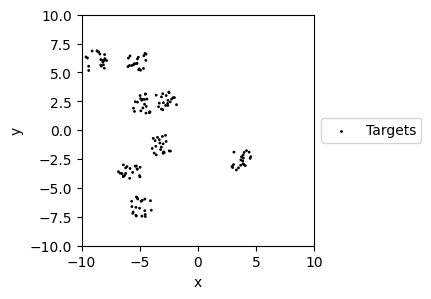

In [4]:
plot_boundary = (10, 10)
ax = None
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

## Section 2 - Different exploration strategies in the patchy environment

Now we will predict and evaluate the behavior of agents with different exploration strategies in the patcy environment. We will pick up on the three types of agents we have worked with so far.

- A random, Brownian random walker
- A simple chemotaxis agent
- A curious infotaxis agent

These are agents that we have used in pervious labs. See those labs to remember how these agents work.


In [5]:
# Agents

# Random search agent
rand = DiffusionGrid(min_length=min_length)
rand.seed(seed_value)

# Common parameters
min_length = 1
p_neg = 0.8
p_pos = 0.2

# Chemotaxis agent
chemo = GradientDiffusionGrid(
    min_length=min_length,
    p_neg=p_neg,
    p_pos=p_pos,
)
chemo.seed(seed_value)


# Infotaxis agent
threshold=0.05
info = GradientInfoGrid(
    min_length=min_length,
    p_neg=p_neg,
    p_pos=p_pos,
    threshold=threshold,
)

info.seed(seed_value)

[52317]

**Note:** you may like to start the next experiments running as you answer these questions.

---
### Question 2.1

Which agent do you think will spend the most time in patches? Which agent do you think will spend the least time in patches? Why?

__Answer:__

The info agent will spend the most time in patches. This is because it compares the probability of finding targets in a current area compared to the past location. This allows it to find areas with higher target density and stay there for the longest time. The random walker will likely spend the least amount of time in the patches. This is because its movement is not relient on information rather on brownian motion patterns so even if it finds a patch it will leave it randomly despite there being mroe targets in that area.

---
### Question 2.2

Which agent do you think will accumulate the most reward (spend the most time next to targets?). Which do you think will spend the least? Why?

I think the info agent will accumulate the most rewards because it is able to rememebr and ues information to find targets and it will spend the most time next to targets as it will want to stay in the patch areas. The random agent will spend the least amount of time next to targets because it can randomly leave patches despite being near many targets.

---
### Question 2.3

Which agent do you think will have the most deaths? Which do you think will have the least? Why?

__Answer:__

The random agent will have the most deaths because it cannot efficiently find patches which might lead to it wandering in the bare areas for an extended period of time. The info taxis agent will likely have the fewest deaths since it will stay in patches and can locate patches faster.

Run the code below to perform a number of experiments, simulating how these different agents behave in the patch environment that you built.

In [6]:
# Experiments
rand_exp = experiment(
    f"rand",
    rand,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
info_exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)


rand:   0%|          | 0/50 [00:00<?, ?it/s]

chemo:   0%|          | 0/50 [00:00<?, ?it/s]

info:   0%|          | 0/50 [00:00<?, ?it/s]

Run the code below to plot behavior of each agent type during one experiment example.

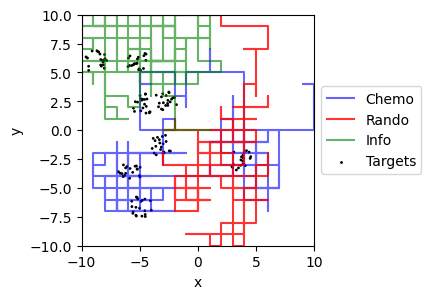

In [7]:
plot_boundary = (10, 10)

# -
num_experiment = num_experiments - 1
ax = None
ax = plot_position2d(
    select_exp(chemo_exp, num_experiment),
    boundary=plot_boundary,
    label="Chemo",
    color="blue",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(rand_exp, num_experiment),
    boundary=plot_boundary,
    label="Rando",
    color="red",
    alpha=0.8,
    ax=ax,
)
ax = plot_position2d(
    select_exp(info_exp, num_experiment),
    boundary=plot_boundary,
    label="Info",
    color="green",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

### Question 2.4

Describe the behavior of each agent type in the experiment visualization above. Does the behavior match what you expected? Why do you think you see the specific pattern of behavior for each agent?

In [8]:
# rando: followed what I expected as it randomly wandered it only found one patch despite covering a lot of space
# chemo: it

### Quantify time on-patches for each agent type

The code below makes use of a new scoring function, `on_off_patch_time()`. This function takes experiment results data and analyzes it to see how many time steps were spent on vs. off patches. Run the code block below to measure and plot the proportion of total time steps each agent spends on patches. See if the results match your predictions.

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

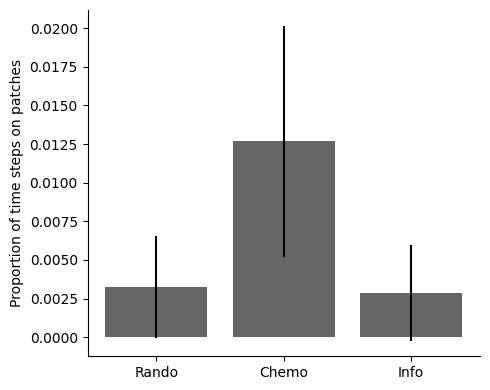

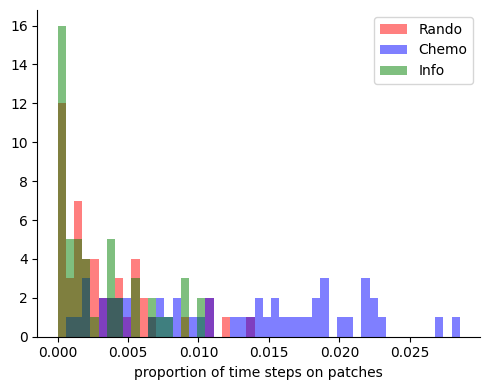

In [9]:
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo","Info"]
colors = ["red", "blue","green"]

# Score by on_patch_time #eff
scores = []
for name, res, color in zip(names, results, colors):
    #scores.append(num_death(res))
    on_patch_steps, off_patch_steps = on_off_patch_time(res, num_experiments, patch_locs, radius)
    scores.append(np.divide(on_patch_steps,(np.array(on_patch_steps) + off_patch_steps)))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Proportion of time steps on patches")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("proportion of time steps on patches")
    plt.tight_layout()
    sns.despine()

### Quantify total reward for each agent type

Check if your predictions were correct.

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

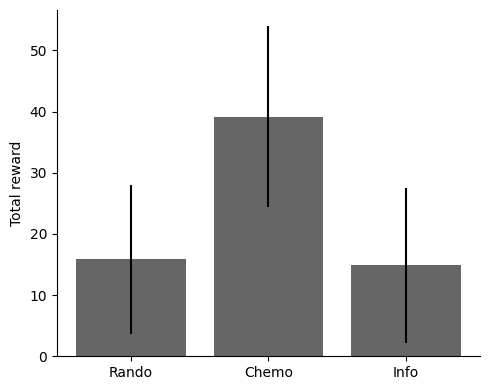

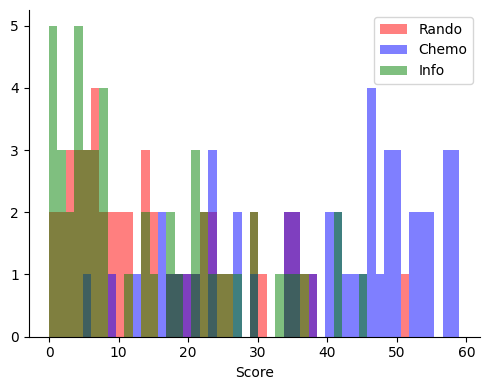

In [10]:
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo","Info"]
colors = ["red", "blue","green"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

### Quantify deaths for each agent type

Check if your predictions were correct.

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

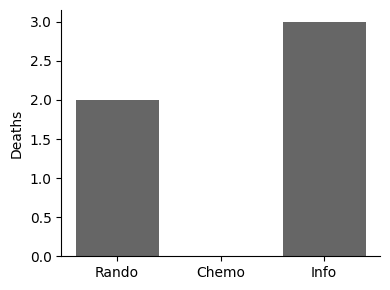

In [11]:
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo", "Info"]
colors = ["red", "blue", "green"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

---
### Question 2.5

Were any of your predictions wrong? If so, what do you think caused the unexpected results?

__Answer:__

Chemo proved to the most effective -- my prediction was wrong. This is becuase info tried to gain information. Chemo on the other hand tried to find the targets by using gradietns makeing it more effective at finding targets in patches and staying alive,

---
### Question 2.6

Compare time on patch, total rewards, and deaths for the Chemo agent. What does this pattern tell you about the influence of a simple chemotaxis strategy for foraging?

__Answer:__

Chemo spend the most time in patches, least deaths, and most rewards. This shows that the strategy was the most effective at patch foraging as it followed the gradeint to targets.

## Section 3 - Exploration strategies in different patchy environments

Let's look at a slightly harder foraging problem: sparse patches. We will create a new patch environment, just like our first one, but with only two patches of 20 targets each.

---
### Question 3.1

Which agent do you predict will do the best in terms of on-patch-proportion, total reward, and death.

__Answer:__

Chemo taxis will be the best due to the above ansers.

Here's how we'll set up the experiment

In [12]:
# Noise and missing scents
p_scent = 0.1
noise_sigma = 2

# Shared agent parameters
num_experiments = 50
num_steps = 500
seed_value = 52317               # seed value for random number generator

# Environment parameters
detection_radius = 1
max_steps = 1
min_length = 1
n_patches = 2 #          # number of patches
n_per_patch = 20 #       # number targets per patch
radius = 3 #             # radius of each patch
target_boundary = (10, 10)

# Generate patches of argets
prng = np.random.RandomState(seed_value)
targets, patch_locs = uniform_patch_targets(n_patches, target_boundary, radius, n_per_patch, prng=prng)

values = constant_values(targets, 1)

# Generate scents from targets
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Create ScentGrid environment
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

Now let's see our environment.

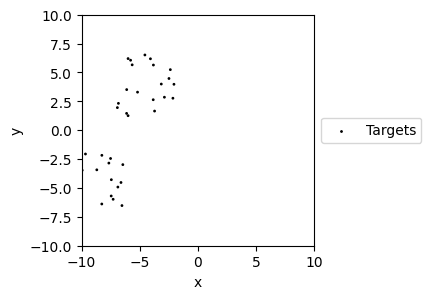

In [13]:
plot_boundary = (10, 10)
num_experiment = 0
ax = None
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

Time to test our agents.

In [14]:
# Experiments
rand_exp = experiment(
    f"rand",
    rand,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
info_exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

rand:   0%|          | 0/50 [00:00<?, ?it/s]

chemo:   0%|          | 0/50 [00:00<?, ?it/s]

info:   0%|          | 0/50 [00:00<?, ?it/s]

First let's take a look at a good demonstration trial. I'm picking one example that will make sense in a little bit.

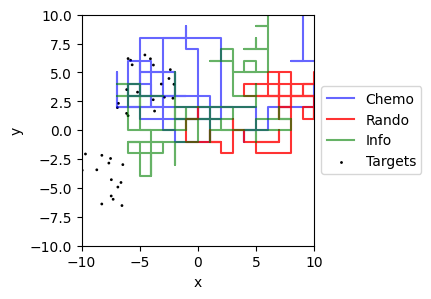

In [15]:
plot_boundary = (10, 10)

# - Picking a good example that is consistent with summary results
num_experiment = 4
ax = None
ax = plot_position2d(
    select_exp(chemo_exp, num_experiment),
    boundary=plot_boundary,
    label="Chemo",
    color="blue",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(rand_exp, num_experiment),
    boundary=plot_boundary,
    label="Rando",
    color="red",
    alpha=0.8,
    ax=ax,
)
ax = plot_position2d(
    select_exp(info_exp, num_experiment),
    boundary=plot_boundary,
    label="Info",
    color="green",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

Okay, now let's take a look at time on patch.

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

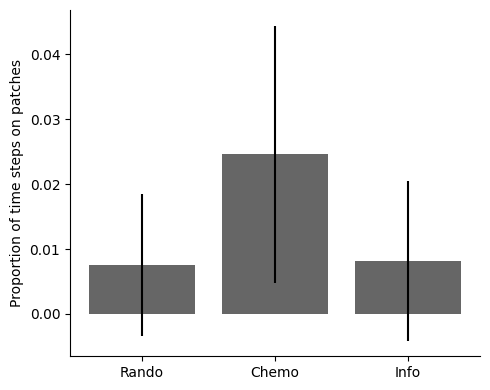

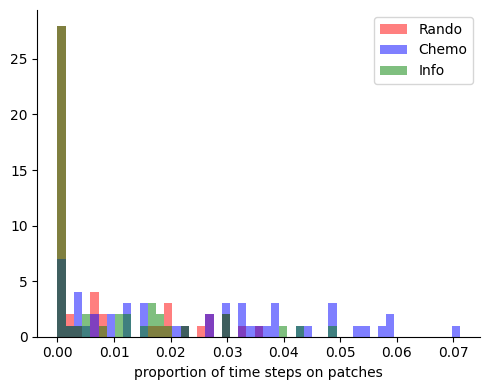

In [16]:
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo", "Info"]
colors = ["red", "blue", "green"]

# Score by on_patch_time #eff
scores = []
for name, res, color in zip(names, results, colors):
    #scores.append(num_death(res))
    on_patch_steps, off_patch_steps = on_off_patch_time(res, num_experiments, patch_locs, radius)
    scores.append(np.divide(on_patch_steps,(np.array(on_patch_steps) + off_patch_steps)))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Proportion of time steps on patches")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("proportion of time steps on patches")
    plt.tight_layout()
    sns.despine()

Interesting patterns that I have some questions about at the end.

Now, let's look at total rewards.

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

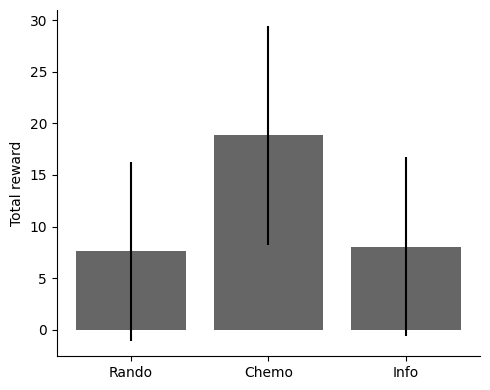

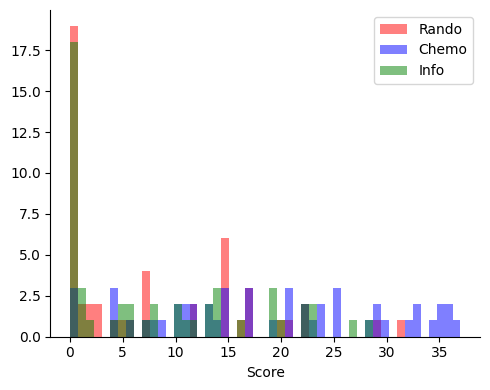

In [17]:
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo", "Info"]
colors = ["red", "blue", "green"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

Interesting. Look at the difference between our chemotaxis agent and our curious (infotaxis) agent.

Now we can look at the contrastive performance measure of deaths.

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

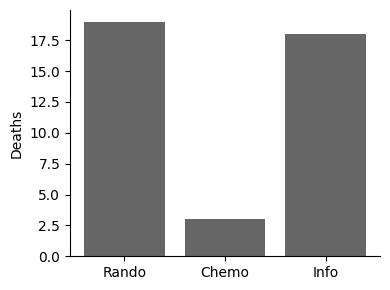

In [18]:
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo", "Info"]
colors = ["red", "blue", "green"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

---
### Question 3.2

Did the results match your predictions? If not, why do you think you saw the results that came up?

__Answer:__

my results matched the predictions. Chemoe had the most rewards, most time in patches, least deaths.

---
### Question 3.3

Re-run the above simulations in Section 3, but change the seed value for the random number generator. Do this four different times, once each with the following values: 2074, 3074, 4074, 5074.

What do you see in the performance of the agents with each new seed value (which specifies different unique environments)?

__Answer:__

2074: chemo did the best, significant increase in deaths, due to not many patches and therefore rewards being there

3074: chemo did the best, large amount of deaths, patches were far away from each other, chemo had trouble following rewards to next patches

4074, chemo did the best, 0 detahs, info 0 deaths, patches were close together but the rewards in the patches were spaced out, this allowed the chemo and info to find and spend time in patches

5074, chemo did the best, numhber of detahs similar across the board, patches in similar areas leading to a lot of competition.


---
**IMPORTANT** Did you collaborate with anyone on this assignment, or use LLMs like ChatGPT? If so, list their names here.
> *Write Name(s) here*